# Pairs Trading Strategy
In this notebook, we want to find a stock pair on which we can do some pairs trading. 

In [1]:
import numpy as np
import seaborn as sn
from src.getSymbols import *
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import yfinance as yf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from src.backtesting.backtesting import *
from src.backtesting.strat import *
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

The first thing we need to do is to find two stocks, which are highly correlated. We could do a big correlation matrix for some list of symbols, but since this scales O(numSymbols), this would probably take some time. Hence, we assume, that our hihghly correlated stocks are in the same industry. As a list of symbols we use the S&P500. Thus in total we compare correlations of S&P500 stocks which are in the same industry

In [2]:
stocksByIndustry = get_SP500_ByIndustries()

c:\Users\seand\git\QuantCodingProjects\src\getSymbols.py:19: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  payload = pd.read_html(response.text)


industry not found for BRK.B
industry not found for BF.B


In [3]:
len(stocksByIndustry[0])

3

In [4]:
# filter out all industries, which only comtain one company
stocksByIndustry = [industry for industry in  stocksByIndustry if len(industry) >1]

In [5]:
numIndustries = len(stocksByIndustry)
print(f"Number of industries which we consider: {numIndustries}")

Number of industries which we consider: 89


In [6]:
def get_historical_as_df(symbols, start_date = datetime(2023, 1, 1), end_date = datetime.now().date()):
    data = pd.DataFrame()
    names = list()

    for symb in symbols:
        ticker = yf.Ticker(symb)
        data = pd.concat([data, pd.DataFrame(ticker.history(start=start_date, end=end_date)["Close"])], axis = 1)
        names.append(symb)
    data.columns = names
    return data

## Select Industry Manually

In [7]:
relevantIndustries = []
print("These are the listed industries:")
for df in stocksByIndustry:
    industry = df.reset_index().loc[0]["industry"]
    print(industry)
    relevantIndustries.append(industry)


These are the listed industries:
Advertising Agencies
Aerospace & Defense
Agricultural Inputs
Airlines
Apparel Retail
Asset Management
Auto Manufacturers
Auto Parts
Banks - Diversified
Banks - Regional
Beverages - Brewers
Beverages - Non-Alcoholic
Biotechnology
Building Materials
Building Products & Equipment
Capital Markets
Communication Equipment
Computer Hardware
Confectioners
Conglomerates
Consulting Services
Credit Services
Diagnostics & Research
Discount Stores
Drug Manufacturers - General
Drug Manufacturers - Specialty & Generic
Electronic Components
Electronic Gaming & Multimedia
Engineering & Construction
Entertainment
Farm & Heavy Construction Machinery
Farm Products
Financial Data & Stock Exchanges
Footwear & Accessories
Healthcare Plans
Home Improvement Retail
Household & Personal Products
Industrial Distribution
Information Technology Services
Insurance - Diversified
Insurance - Life
Insurance - Property & Casualty
Insurance Brokers
Integrated Freight & Logistics
Internet 

**Pick The industry you want to analyse**

In [9]:
industry = "Tobacco"

In [10]:
idx_industry = 0
for i in range(len(stocksByIndustry)):
    if industry == stocksByIndustry[i].reset_index().loc[0]["industry"]:
        idx_industry = i
        break
else:
    print("industry not found. please check if you selected a valid industry")

In [11]:
symbs = stocksByIndustry[idx_industry]["symbol"].to_list()
data = get_historical_as_df(symbs)

In [12]:
corr_matrix = data.corr()
corr_matrix

,MO,PM
MO,1.000000,0.964592
PM,0.964592,1.000000


<Axes: >

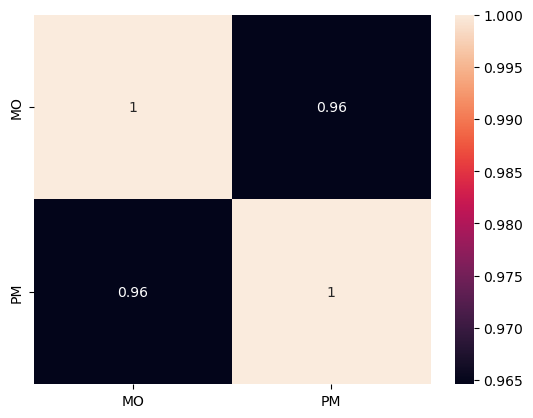

In [13]:
sn.heatmap(corr_matrix, annot = True)

## Automatically Pick N Pairs with high correlation

In [14]:
# Number of pairs you want to get
N = 20

In [15]:
listStockPairs = [("","", 0, "") for i in range(N)]
for i in range(numIndustries):
    symbols = stocksByIndustry[i]["symbol"].to_list()
    numStocksInIndustry = len(symbols)
    df = get_historical_as_df(symbols)
    corr_matrix = df.corr()
    for j in range(numStocksInIndustry):
        for k in range(j):

            if corr_matrix.iloc[j,k]> listStockPairs[-1][2]:
                listStockPairs[-1] = (corr_matrix.columns[j],corr_matrix.columns[k], corr_matrix.iloc[j,k], stocksByIndustry[i]["industry"].iloc[0])
                listStockPairs.sort(key=lambda x: -x[2])
        


In [16]:
listStockPairs

[('GOOG',
  'GOOGL',
  np.float64(0.9999064770530861),
  'Internet Content & Information'),
 ('FOX', 'FOXA', np.float64(0.9989491250697718), 'Entertainment'),
 ('SPGI',
  'MCO',
  np.float64(0.9922198746512344),
  'Financial Data & Stock Exchanges'),
 ('WMB', 'KMI', np.float64(0.9868972648396204), 'Oil & Gas Midstream'),
 ('NI', 'ATO', np.float64(0.9866488897176348), 'Utilities - Regulated Gas'),
 ('PNC', 'FITB', np.float64(0.9862318998384667), 'Banks - Regional'),
 ('PPL',
  'CMS',
  np.float64(0.98618181484725),
  'Utilities - Regulated Electric'),
 ('PNR',
  'PH',
  np.float64(0.9843797936721884),
  'Specialty Industrial Machinery'),
 ('PAYX', 'ADP', np.float64(0.9831287962798011), 'Software - Application'),
 ('NWS', 'NWSA', np.float64(0.9827801315281401), 'Entertainment'),
 ('WEC',
  'AEE',
  np.float64(0.982722165597269),
  'Utilities - Regulated Electric'),
 ('DTE',
  'CMS',
  np.float64(0.9820514647830009),
  'Utilities - Regulated Electric'),
 ('WFC', 'JPM', np.float64(0.981998

## Do some time series analysis on the increments of selected stocks

For each of these time series pairs, we now need to compute the increments and see, if we need to adjust the timeserieses to make the increment ts stationary. For this, we scale the respective stocks up such that the mean square of the time series gets minimized, i.e. we want to minimize

$\argmin \limits _{a >0} \mathbb E [~  ( S_2 - a \cdot S_1)^2 ~ ] $
 
where $S_1, S_2$ are the time serieses of the stocks. 
Note that this is just simple linear regression without intercept.
Thus we get the optimal value for $a$ from

$a = { \mathbb E [S_1 \cdot S_2 ] \over E[S_1^2]}$

Note that this is different to case where we would have minimized

$\argmin \limits _{a >0} \mathbb E [~  ( S_1 - a \cdot S_2)^2 ~ ] $

where we would have gotten

$\tilde a = { \mathbb E [S_1 \cdot S_2 ] \over E[S_2^2]}$

In [39]:
symb1 = 'DTE'
symb2 = 'CMS'
ticker1 = yf.Ticker(symb1)
ticker2 = yf.Ticker(symb2)
start_date = datetime(2022, 1, 1)
end_date = datetime(2025, 1, 1) #.now().date()#
x = ticker1.history(start=start_date, end=end_date)["Close"]#.to_numpy()
x_np = x.to_numpy()
y = ticker2.history(start=start_date, end=end_date)["Close"]#.to_numpy()
y_np = y.to_numpy()

#here we compute the regression coeff a as described above
scalingFactor = np.round(np.mean(x.to_numpy() *y.to_numpy()) / np.mean(x.to_numpy()*x.to_numpy()), decimals= 3) # we round this to 3 decimal to compute portions in which we buy stocks
a_x = 1000*scalingFactor
a_y = 1000
scalingFactor

np.float64(0.538)

In [40]:
# this is the computation of a tilde, as described above
1/(np.mean(x.to_numpy() *y.to_numpy()) / np.mean(y.to_numpy()*y.to_numpy())) 

np.float64(0.5387859071566632)

But still ${1 \over \tilde a} \approx a$ are very similar. Thus we can use $a = { \mathbb E [S_1 \cdot S_2 ] \over E[S_1^2]}$ with a good conscience.

In [41]:
a_x

np.float64(538.0)

In [25]:
a_y

1000

Text(0.5, 1.0, 'Stocks (scaled)')

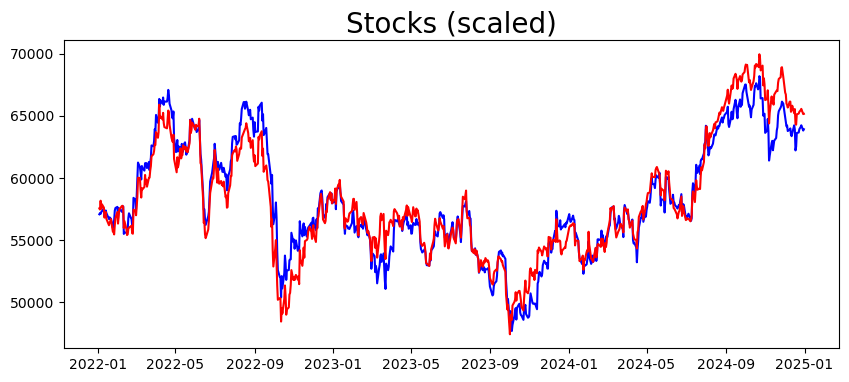

In [26]:
plt.figure(figsize=(10,4))
plt.plot(a_x*x, 'b')
plt.plot(a_y*y, 'r')
plt.title('Stocks (scaled)', fontsize=20)

Text(0.5, 1.0, 'Stocks (not scaled)')

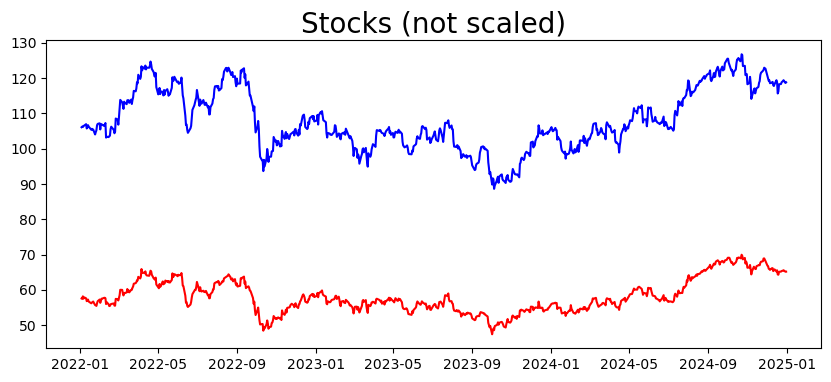

In [27]:
plt.figure(figsize=(10,4))
plt.plot(x, 'b')
plt.plot(y, 'r')
plt.title('Stocks (not scaled)', fontsize=20)

In [28]:
increments = a_x*x - a_y*y
increments_np = increments.to_numpy()

Text(0.5, 1.0, 'Increments (of scaled scaled stocks)')

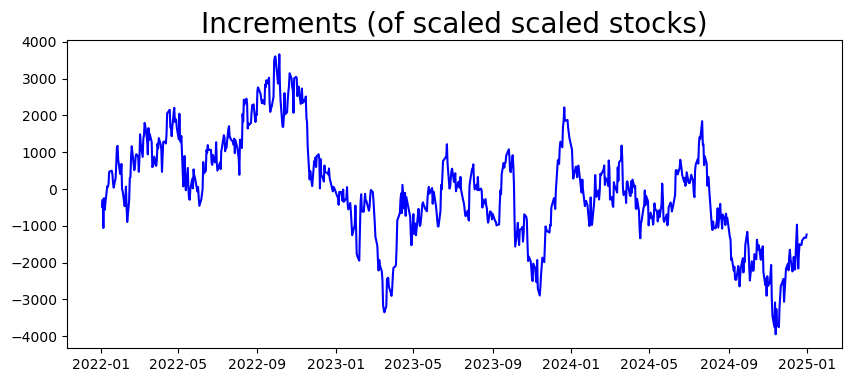

In [29]:
plt.figure(figsize=(10,4))
plt.plot(increments, 'b')
plt.title('Increments (of scaled scaled stocks)', fontsize=20)

In [ ]:
thresholdSell = np.percentile(np.abs(increments_np), 30)
thresholdBuy = np.percentile(np.abs(increments_np), 95)

Text(0.5, 1.0, 'Increments (absolute difference)')

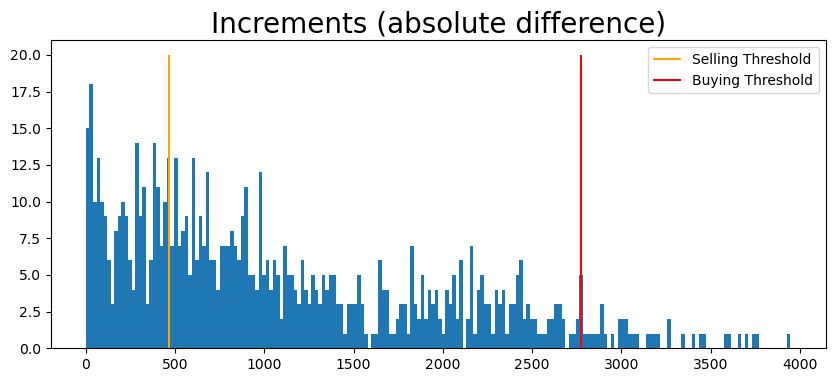

In [32]:
plt.figure(figsize=(10,4))
plt.hist(np.abs(increments_np), bins=200)
plt.vlines(thresholdSell, ymax= 20, ymin=0, label="Selling Threshold", colors="orange")
plt.vlines(thresholdBuy, ymax= 20, ymin=0, label="Buying Threshold", colors="r")
plt.legend()
plt.title('Increments (absolute difference)', fontsize=20)

In [33]:
adfuller(increments_np)

(np.float64(-2.934871384612045),
 np.float64(0.04144061379394273),
 2,
 750,
 {'1%': np.float64(-3.439099096730074),
  '5%': np.float64(-2.8654013553540745),
  '10%': np.float64(-2.568826193777778)},
 np.float64(10645.63563847472))

ADF test gives us a p value of 0.04, which is significant to us. Thus we can assume that our increments are stationary. So let's build our pairs trading strategy. Note that we only testet the time series up until 1/1/2025. Now we would like to see how mean reversion performs up until today

In [ ]:
class PairsTradingStrategy(Strategy):
    def __init__(self, numShares1_ToBuy_perTrade, numShares2_ToBuy_perTrade, thresholdBuy, thresholdSell):
        self.numShares1_ToBuy_perTrade = numShares1_ToBuy_perTrade
        self.numShares2_ToBuy_perTrade = numShares2_ToBuy_perTrade
        self.thresholdBuy =thresholdBuy
        self.thresholdSell = thresholdSell

    def updatePortfolio(self, oldPortfolio, cash, pricesAssets, assets):
        increments = self.numShares1_ToBuy_perTrade* pricesAssets[0] - self.numShares2_ToBuy_perTrade* pricesAssets[1]
        abs_increments = np.abs(increments)
        if abs_increments > self.thresholdBuy:
            cashMinusDebt = cash - np.minimum(oldPortfolio[0], 0)*pricesAssets[0] - np.minimum(oldPortfolio[1], 0)*pricesAssets[1]
            factorBuy = cashMinusDebt // (pricesAssets[0] *self.numShares1_ToBuy_perTrade  + pricesAssets[1]*self.numShares2_ToBuy_perTrade)
            if factorBuy >= 1:
                if increments > 0 : 
                    return [-factorBuy*self.numShares1_ToBuy_perTrade, factorBuy*self.numShares2_ToBuy_perTrade]
                else:
                    return [factorBuy*self.numShares1_ToBuy_perTrade, -factorBuy*self.numShares2_ToBuy_perTrade]
            return [0,0]
        elif abs_increments < self.thresholdSell:
            return [0,0]
        
        else:
            return oldPortfolio

In [ ]:
numShares1_ToBuy_perTrade, numShares2_ToBuy_perTrade = 538.0, 1000
myStrat = PairsTradingStrategy(numShares1_ToBuy_perTrade, numShares2_ToBuy_perTrade, thresholdBuy, thresholdSell)

testStart = datetime(2025,1,1)
testEnd = datetime.now().date()
df1 = yf.download(symb1, start = testStart , end = testEnd)
df2 = yf.download(symb2, start = testStart, end = testEnd)
df1.columns = df1.columns.get_level_values('Price')
df2.columns = df2.columns.get_level_values('Price')
bt = Backtester([df1,df2], myStrat, 
                capital=1000000)

bt.run()


C:\Users\seand\AppData\Local\Temp\ipykernel_11064\4215094827.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df1 = yf.download(symb1, start = testStart , end = testEnd)
[*********************100%***********************]  1 of 1 completed
C:\Users\seand\AppData\Local\Temp\ipykernel_11064\4215094827.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df2 = yf.download(symb2, start = testStart, end = testEnd)
[*********************100%***********************]  1 of 1 completed


In [ ]:
bt.reportResults()

  Start Capital    Final Capital    Absolute Gains  Relative Gains      Volatility (via log returns)    Number Of Dates With Trades    Number Trading Days
---------------  ---------------  ----------------  ----------------  ------------------------------  -----------------------------  ---------------------
        1000000      1.02284e+06             22841  2.28%                                  0.0386603                              7                    160


In [ ]:
bt.plot()

# Industry Trading
We want to try a strategy next, which is basically like pairs trading strategy but for multiple stocks in one industry.

For this let us first identify an industry with multiple highly correlated stocks. Concretely, we will have a look at the VIFs of stocks within an industry.

## Select Industry Manually

In [7]:
industryIndex = 5
symbols = stocksByIndustry[industryIndex]["symbol"].to_list()
numStocksInIndustry = len(symbols)
df = get_historical_as_df(symbols)
        

In [8]:
df_with_const = add_constant(df)
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i + 1) for i in range(len(df.columns))]


In [9]:
vif_data["VIF"]

0     142.231118
1      74.771177
2      53.042528
3      46.374556
4       3.617210
5      11.194434
6      68.205138
7      39.208827
8       4.207253
9      48.182241
10     34.548940
11      4.355984
Name: VIF, dtype: float64

## Select Industry Automatically Based On Industry with highest VIF

In [642]:
start_date = datetime(2023, 1, 1)
end_date = datetime.now().date()#(2025, 1, 1) #

In [643]:
maxVIF = 0
idxBestIndustry = -1
excludeIndustry = ["Internet Content & Information", "Entertainment","Asset Management"]#, "Utilities - Regulated Electric","Financial Data & Stock Exchanges"] # these are the industries, which we want to exclude for any reason. E.g. They have only two stocks with very hihg VIF.
for i in range(numIndustries):
    if stocksByIndustry[i] ["industry"] [0] in excludeIndustry:
        continue
    symbols = stocksByIndustry[i]["symbol"].to_list()

    # if only 2 or less stocks in this industry ingnore it
    if len(symbols)<3:
        continue

    numStocksInIndustry = len(symbols)
    df = get_historical_as_df(symbols, start_date=start_date, end_date= end_date)
    df_with_const = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    try:
        vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i + 1) for i in range(len(df.columns))]
        maxSampleVIF = vif_data["VIF"].max()
        if maxVIF < maxSampleVIF:
            maxVIF = maxSampleVIF
            idxBestIndustry = i
    except:
        pass

        

In [644]:
print(f"max VIF ({maxVIF}) was found in {stocksByIndustry[idxBestIndustry] ["industry"] [0]}")

max VIF (210.13019641102358) was found in Utilities - Regulated Electric


In [645]:
industryIndex = idxBestIndustry
symbols = stocksByIndustry[industryIndex]["symbol"].to_list()
numStocksInIndustry = len(symbols)
df = get_historical_as_df(symbols, start_date=start_date, end_date= end_date)

df_with_const = add_constant(df)
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i + 1) for i in range(len(df.columns))]
print(vif_data["VIF"])
# We drop the stocks which have a low VIF (below 10), since they are not relevant for our strategy
filteredSymbols = [symbols[ i] for i in range(len(symbols)) if vif_data["VIF"].to_list()[i] >30 ]

0     140.328550
1     177.969142
2      92.863441
3      22.595188
4     180.297211
5      49.827498
6      53.546072
7     128.109823
8      95.785350
9      22.323281
10    210.130196
11     90.757154
12     32.434620
13     33.201839
14     24.111343
15     12.103649
16     13.838775
17     60.305924
18    179.237837
19     64.052099
20    106.934613
21    170.534296
22     28.261368
Name: VIF, dtype: float64


In [646]:
filteredSymbols
numStocksInIndustry = len(filteredSymbols)
df = get_historical_as_df(filteredSymbols, start_date=start_date, end_date = end_date)

df_with_const = add_constant(df)
vif_data_filtered = pd.DataFrame()
vif_data_filtered["feature"] = df.columns
vif_data_filtered["VIF"] = [variance_inflation_factor(df_with_const.values, i + 1) for i in range(len(df.columns))]

In [647]:
vif_data_filtered["VIF"]

0     100.221627
1     156.996739
2      70.786466
3     131.129531
4      40.516901
5      41.555898
6      82.478012
7      86.190370
8     142.409840
9      70.134047
10     28.508966
11     24.422862
12     37.624808
13    137.512815
14     43.219824
15     89.987760
16    150.625264
Name: VIF, dtype: float64

To find the right scaling facotrs for the stocks as before, we proceed with a linear regression model without intercept. This time we choose the variable with the highest VIF as our regressand and the other stocks will be the predictors.

In [648]:
idxHighestVIF = -1
nStocks = len(vif_data_filtered["VIF"])
maxVif = max(vif_data_filtered["VIF"].to_list())
for i in range(nStocks):
    if vif_data_filtered["VIF"][i] == maxVif:
        idxHighestVIF = i
        break

In [649]:
X = df.to_numpy()[:, [i for i in range(nStocks) if i != idxHighestVIF]]
Y = df.to_numpy()[:, idxHighestVIF]
reg = LinearRegression(fit_intercept=False).fit(X, Y)

In [650]:
scalarfactor = 100
numSharesPerMovement = reg.coef_ *scalarfactor
numSharesPerMovement = numSharesPerMovement.round()
numSharesPerMovement

array([ 63.,  -1.,   6.,  -8.,  -8., -26., -13.,  22.,  17.,  14.,  70.,
         9.,  25.,   7., -14.,  38.])

In [651]:
symbVIFHighest = vif_data_filtered.feature.iloc[idxHighestVIF]
filteredSymbols.pop(idxHighestVIF)


'AEE'

In [652]:
filteredSymbols

['LNT',
 'AEP',
 'CMS',
 'ED',
 'D',
 'DTE',
 'DUK',
 'ETR',
 'EVRG',
 'ES',
 'EXC',
 'PNW',
 'PPL',
 'PEG',
 'SO',
 'WEC']

Let's see if our proportions create a stationary time series!

In [653]:
scaledStocks = []
for i in range(nStocks -1 ):
        scaledStocks.append(X[:, i] * numSharesPerMovement[i] )
scaledStocks.append(Y * (-scalarfactor))

scaledStocks = np.array(scaledStocks)

In [654]:
multiincrements = scaledStocks.sum(axis=0)

C:\Users\seand\AppData\Local\Temp\ipykernel_30608\1176253094.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df.index, multiincrements,  'b')


Text(0.5, 1.0, 'Increments (of scaled scaled stocks)')

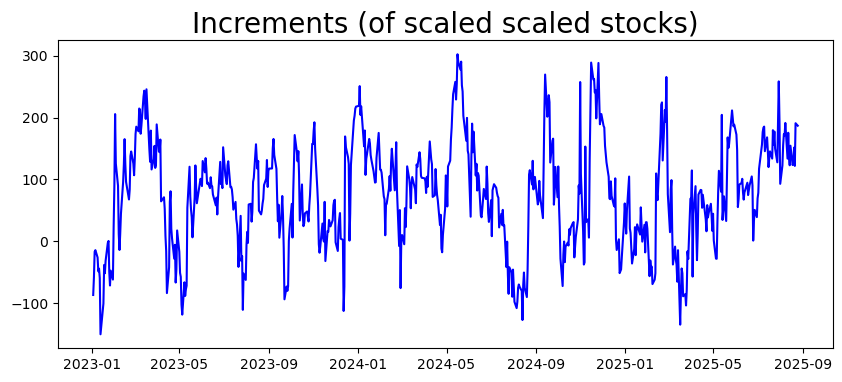

In [655]:
plt.figure(figsize=(10,4))
plt.plot_date(df.index, multiincrements,  'b')
plt.title('Increments (of scaled scaled stocks)', fontsize=20)

In [656]:
adfuller(multiincrements)

(np.float64(-6.43522986334012),
 np.float64(1.6591936636762706e-08),
 1,
 661,
 {'1%': np.float64(-3.4402817347322583),
  '5%': np.float64(-2.8659224464259823),
  '10%': np.float64(-2.5691038118332603)},
 np.float64(6686.109424978414))

Very Significant and R squared very high!

In [726]:
thresholdSellMulti = np.percentile(np.abs(multiincrements), 30)
thresholdBuyMulti = np.percentile(np.abs(multiincrements), 95)
print(thresholdSellMulti)
print(thresholdBuyMulti)

51.57159347534179
217.4674655914306


Text(0.5, 1.0, 'Multiincrements (absolute value)')

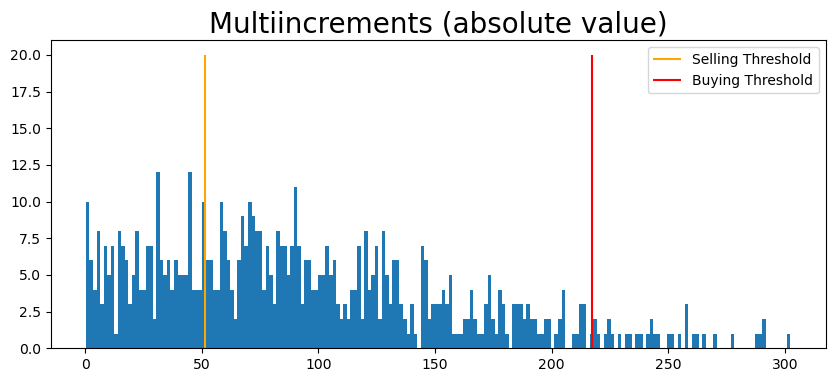

In [727]:
plt.figure(figsize=(10,4))
plt.hist(np.abs(multiincrements), bins=200)
plt.vlines(thresholdSellMulti, ymax= 20, ymin=0, label="Selling Threshold", colors="orange")
plt.vlines(thresholdBuyMulti, ymax= 20, ymin=0, label="Buying Threshold", colors="r")
plt.legend()
plt.title('Multiincrements (absolute value)', fontsize=20)

## Let's finaly build the strategy!

In [728]:
class IndustryTradingStrategy(Strategy):
    def __init__(self, numSharesPerMovement,thresholdMulti_Sell,  thresholdMulti_Buy):
        self.numSharesPerMovement = numSharesPerMovement
        self.thresholdMulti_Sell = thresholdMulti_Sell
        self.thresholdMulti_Buy = thresholdMulti_Buy

    def updatePortfolio(self, oldPortfolio, cash, pricesAssets, assets):
        multiincrements = 0
        for i in range(len(pricesAssets)):
            multiincrements += self.numSharesPerMovement[i] *pricesAssets[i]


        abs_multiincrements = np.abs(multiincrements)

        if abs_multiincrements > self.thresholdMulti_Buy:
            cashMinusDebt = cash - np.minimum(oldPortfolio[0], 0)*pricesAssets[0] - np.minimum(oldPortfolio[1], 0)*pricesAssets[1]
            for i in range(len(pricesAssets)):
                cashMinusDebt -= np.minimum(oldPortfolio[i], 0)*pricesAssets[i]
            
            costBuyOneMovement = 0
            for i in range(len(pricesAssets) ):
                costBuyOneMovement +=  np.abs( pricesAssets[i]*self.numSharesPerMovement[i])

            factorBuy = cashMinusDebt // costBuyOneMovement
            if factorBuy >= 1:
                if multiincrements > 0 : 
                    return [ - factorBuy* numShare for numShare in self.numSharesPerMovement]
                else:
                    return [factorBuy* numShare for numShare in self.numSharesPerMovement]
            return [0 for i in range(len(pricesAssets))]
        elif abs_multiincrements < self.thresholdMulti_Sell:
            return [0 for i in range(len(pricesAssets))]
        
        else:
            return oldPortfolio

In [729]:
numSharesPerMovementTotal = numSharesPerMovement.tolist() + [- scalarfactor]
myStratMulit = IndustryTradingStrategy(numSharesPerMovementTotal,thresholdMulti_Buy=thresholdBuyMulti,  thresholdMulti_Sell=thresholdSellMulti)

testStart = start_date
testEnd = end_date


total_data = []
for i in range(nStocks -1):
    df_aux = yf.download(filteredSymbols[i], start = testStart , end = testEnd)
    df_aux.columns = df_aux.columns.get_level_values('Price')
    total_data.append(df_aux)


dfHighVIF = yf.download(symbVIFHighest, start = testStart , end = testEnd)
dfHighVIF.columns = dfHighVIF.columns.get_level_values('Price')

total_data.append(dfHighVIF)

bt = Backtester(total_data, myStratMulit, 
                capital=1000000)

C:\Users\seand\AppData\Local\Temp\ipykernel_30608\275294808.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_aux = yf.download(filteredSymbols[i], start = testStart , end = testEnd)
[*********************100%***********************]  1 of 1 completed
C:\Users\seand\AppData\Local\Temp\ipykernel_30608\275294808.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_aux = yf.download(filteredSymbols[i], start = testStart , end = testEnd)
[*********************100%***********************]  1 of 1 completed
C:\Users\seand\AppData\Local\Temp\ipykernel_30608\275294808.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_aux = yf.download(filteredSymbols[i], start = testStart , end = testEnd)
[*********************100%***********************]  1 of 1 completed
C:\Users\seand\AppData\Local\Temp\ipykernel_30608\275294808.py:10: FutureWarning: YF.download() has changed argument auto_ad

In [730]:
bt.run()

In [731]:
bt.reportResults()

  Start Capital    Final Capital    Absolute Gains  Relative Gains      Volatility (via log returns)    Number Of Dates With Trades    Number Trading Days
---------------  ---------------  ----------------  ----------------  ------------------------------  -----------------------------  ---------------------
        1000000      1.04328e+06           43280.2  4.33%                                  0.0290963                             44                    663


In [732]:
bt.plot()